# AFL Time Series Data Analysis with Result and AFL Fantasy Predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, zscore

%matplotlib inline

#Supresses scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("stats.csv")

df.head()

,Team,Player,D.O.B,Height,Weight,Position,Season,Round,Date,Score,Margin,WinLoss,Opposition,Venue,Disposals,Kicks,Marks,Handballs,Goals,Behinds,Hitouts,Tackles,Rebound50s,Inside50s,Clearances,Clangers,FreesFor,FreesAgainst,BrownlowVotes,ContendedPossessions,UncontendedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces,GoalAssists,PercentPlayed
0,Adelaide,"Atkins, Rory",1994-07-12,186,85,Midfield,2018,R1,2018-03-23,87.00,-12.00,L,Essendon,Docklands,14,8,1,6,0,2,0,2,2,4,1,1,1,0,0,4,9,0,0,0,0,1,86
1,Adelaide,"Betts, Eddie",1986-11-26,174,74,Forward,2018,R1,2018-03-23,87.00,-12.00,L,Essendon,Docklands,14,7,2,7,0,2,0,2,0,1,1,1,1,0,0,6,9,0,1,3,0,1,85
2,Adelaide,"Brown, Luke",1992-09-22,181,81,Defender,2018,R1,2018-03-23,87.00,-12.00,L,Essendon,Docklands,15,10,2,5,0,0,0,0,5,1,0,0,0,0,0,1,10,0,0,2,0,0,82
3,Adelaide,"Crouch, Matt",1995-04-21,182,80,Midfield,2018,R1,2018-03-23,87.00,-12.00,L,Essendon,Docklands,41,18,6,23,0,0,0,2,3,3,7,4,0,1,0,11,31,0,0,0,0,1,80
4,Adelaide,"Doedee, Tom",1997-03-01,188,88,Defender,2018,R1,2018-03-23,87.00,-12.00,L,Essendon,Docklands,21,7,7,14,0,0,0,2,4,1,0,2,2,0,0,8,14,0,0,9,1,0,93


In [3]:
df.dtypes

Team                       object
Player                     object
D.O.B                      object
Height                      int64
Weight                      int64
Position                   object
Season                      int64
Round                      object
Date                       object
Score                     float64
Margin                    float64
WinLoss                    object
Opposition                 object
Venue                      object
Disposals                   int64
Kicks                       int64
Marks                       int64
Handballs                   int64
Goals                       int64
Behinds                     int64
Hitouts                     int64
Tackles                     int64
Rebound50s                  int64
Inside50s                   int64
Clearances                  int64
Clangers                    int64
FreesFor                    int64
FreesAgainst                int64
BrownlowVotes               int64
ContendedPosse

### Creating "Age" column:

In [4]:
#Converting date objects to datetime:
df['D.O.B'] = pd.to_datetime(df['D.O.B'], format='%Y'+'-'+'%m'+'-'+'%d')
df['Date'] = pd.to_datetime(df['Date'], format='%Y'+'-'+'%m'+'-'+'%d')

#Creating Age column:
df.insert(2,'Age',(df['Date']-df['D.O.B'])/np.timedelta64(1,'Y'))

df.drop('D.O.B',axis=1,inplace=True)

#Changing WinLoss to numerical values
df.WinLoss.replace(['W', 'L', 'D'],[1,0,.5],inplace=True)

### Fixing Null Values:

In [5]:
#Removing post season "Rounds" (they also have null values)
round_list = ['QF', 'SF', 'PF', 'GF', 'EF']
df = df[~df.Round.isin(round_list)]

### Creating an alphabetically sorted "Team, Opposition" column to be able to group by game:

In [6]:
df['Teams'] = df[['Team','Opposition']].values.tolist()

In [7]:
df.Teams = df.Teams.apply(sorted).apply(', '.join)

### Creating Points Per Percent Played column:

In [8]:
#Creating "points per percent of game played" columns
df.insert(10, 'PointsPerPercentPlayed',(df['Goals']+df['Behinds'])/df['PercentPlayed'])

## Feature info:

In [9]:
df.describe()

,Age,Height,Weight,Season,Score,PointsPerPercentPlayed,Margin,WinLoss,Disposals,Kicks,Marks,Handballs,Goals,Behinds,Hitouts,Tackles,Rebound50s,Inside50s,Clearances,Clangers,FreesFor,FreesAgainst,BrownlowVotes,ContendedPossessions,UncontendedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces,GoalAssists,PercentPlayed
count,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00
mean,24.96,187.76,88.07,2015.00,88.53,0.01,0.00,0.50,16.73,9.43,4.08,7.31,0.58,0.42,1.83,2.99,1.57,2.34,1.70,2.21,0.84,0.84,0.14,6.40,10.28,0.49,0.53,2.15,0.38,0.40,81.81
std,3.68,7.20,8.08,2.00,27.81,0.02,46.17,0.50,7.21,4.56,2.55,4.36,0.99,0.74,6.74,2.30,1.75,1.92,2.22,1.64,0.99,0.98,0.55,3.71,5.31,0.85,0.99,2.33,0.93,0.68,13.32
min,18.27,167.00,67.00,2012.00,17.00,0.00,-162.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,22.07,183.00,82.00,2013.00,69.00,0.00,-30.00,0.00,11.00,6.00,2.00,4.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,4.00,6.00,0.00,0.00,1.00,0.00,0.00,79.00
50%,24.61,187.00,86.00,2015.00,86.00,0.00,0.00,0.50,16.00,9.00,4.00,7.00,0.00,0.00,0.00,3.00,1.00,2.00,1.00,2.00,1.00,1.00,0.00,6.00,10.00,0.00,0.00,1.00,0.00,0.00,84.00
75%,27.49,193.00,93.00,2017.00,106.00,0.02,30.00,1.00,21.00,12.00,6.00,10.00,1.00,1.00,0.00,4.00,2.00,3.00,3.00,3.00,1.00,1.00,0.00,8.00,14.00,1.00,1.00,3.00,0.00,1.00,89.00
max,41.26,211.00,118.00,2018.00,193.00,0.25,162.00,1.00,54.00,36.00,21.00,35.00,13.00,7.00,80.00,19.00,16.00,16.00,18.00,13.00,9.00,8.00,3.00,32.00,40.00,8.00,13.00,25.00,15.00,6.00,100.00


In [10]:
number_list = df.select_dtypes(include=['number']).columns

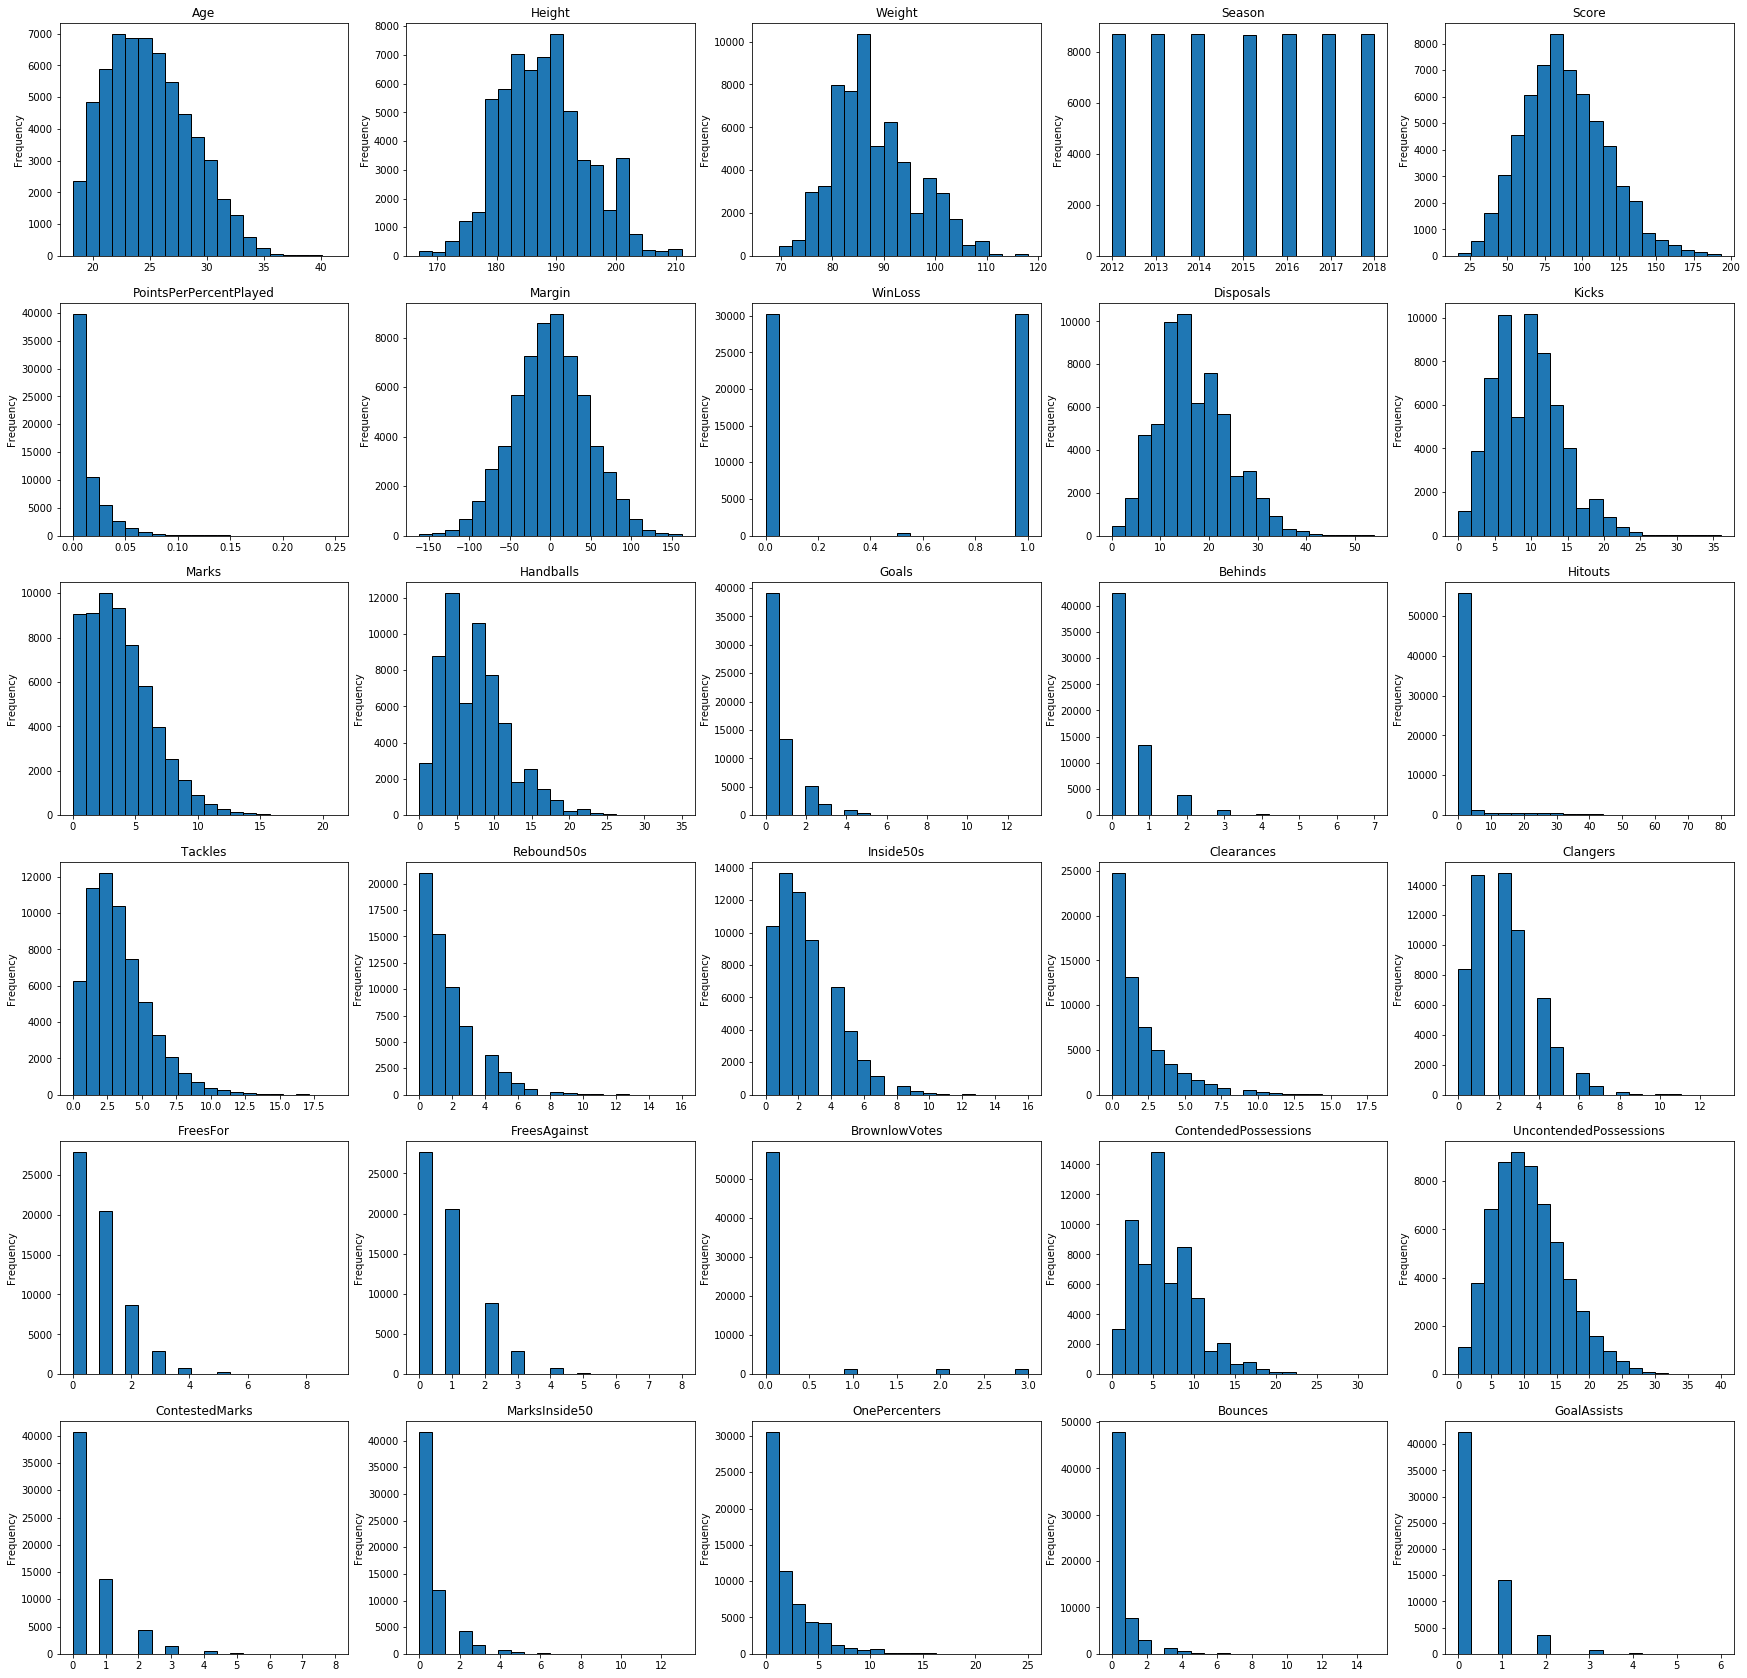

In [11]:
fig,ax = plt.subplots(6, 5)

m=0
for i in range(6):
    for j in range(5):

        df[number_list[m]].plot(kind='hist',bins=20,ax=ax[i,j],figsize=(30, 30),
                                edgecolor='k').set_title(number_list[m])
        m+=1

In [12]:
df = df.set_index(['Season','Round']).sort_index()

# Predicting the outcome of a game:

## Normalizing all players by round (n1):

In [13]:
df_ML = df.copy()

In [14]:
scaling_list = ['PointsPerPercentPlayed','Disposals', 'Kicks', 'Marks','Handballs',
                'Goals', 'Behinds','Hitouts', 'Tackles', 'Rebound50s','Inside50s',
                'Clearances','Clangers', 'FreesFor', 'FreesAgainst','BrownlowVotes',
                'ContendedPossessions', 'UncontendedPossessions','ContestedMarks',
                'MarksInside50', 'OnePercenters', 'Bounces', 'GoalAssists']

normalize_list = ['Age', 'Height', 'Weight', 'Score', 'Margin']

#Copying lists for AFL Fantasy analysis below:
new_scaling_list = scaling_list.copy()
new_normalize_list = normalize_list.copy()

lose = ['Age', 'Height', 'Weight'] #For rows that I don't want to shift

In [15]:
templist=[]
for col in scaling_list:
    df_ML[col+'_n1'] = df_ML.groupby(['Season','Round'])[col].transform(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)))    
    templist.append(col+'_n1')

scaling_list += templist

In [16]:
templist=[]
for col in normalize_list:
    df_ML[col+'_n1'] = df_ML.groupby(['Season','Round'])[col].transform(lambda x: zscore(x,ddof=1))
    templist.append(col+'_n1')
    
    if col.startswith('Age')|col.startswith('Height')|col.startswith('Weight'):
        lose.append(col+'_n1')

normalize_list += templist

## Normalizing further by game (n2):

In [17]:
df_ML = df_ML.set_index(['Teams'],append=1).sort_index()

In [18]:
templist=[]
for col in scaling_list:
    df_ML[col+'_n2'] = df_ML.groupby(['Season','Round','Teams'])[col].transform(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)))
    templist.append(col+'_n2')

scaling_list += templist

In [19]:
templist=[]
for col in normalize_list:
    df_ML[col+'_n2'] = df_ML.groupby(['Season','Round','Teams'])[col].transform(lambda x: zscore(x,ddof=1))
    templist.append(col+'_n2')
    
    if col.startswith('Age')|col.startswith('Height')|col.startswith('Weight'):
        lose.append(col+'_n2')

normalize_list += templist

In [20]:
df_ML.fillna(0,inplace=True) # Eliminates NaN values created during normalization

## Points per percent of game played relative to other players that round by position:

In [21]:
print(df_ML.Position.value_counts())

hist_names = df_ML.Position.value_counts().index.drop('Midfield, Ruck')

Defender              20950
Forward               15047
Midfield              14970
Midfield, Forward      4216
Ruck                   3111
Forward, Ruck          1099
Defender, Midfield      775
Defender, Forward       771
Midfield, Ruck            1
Name: Position, dtype: int64


## Age:

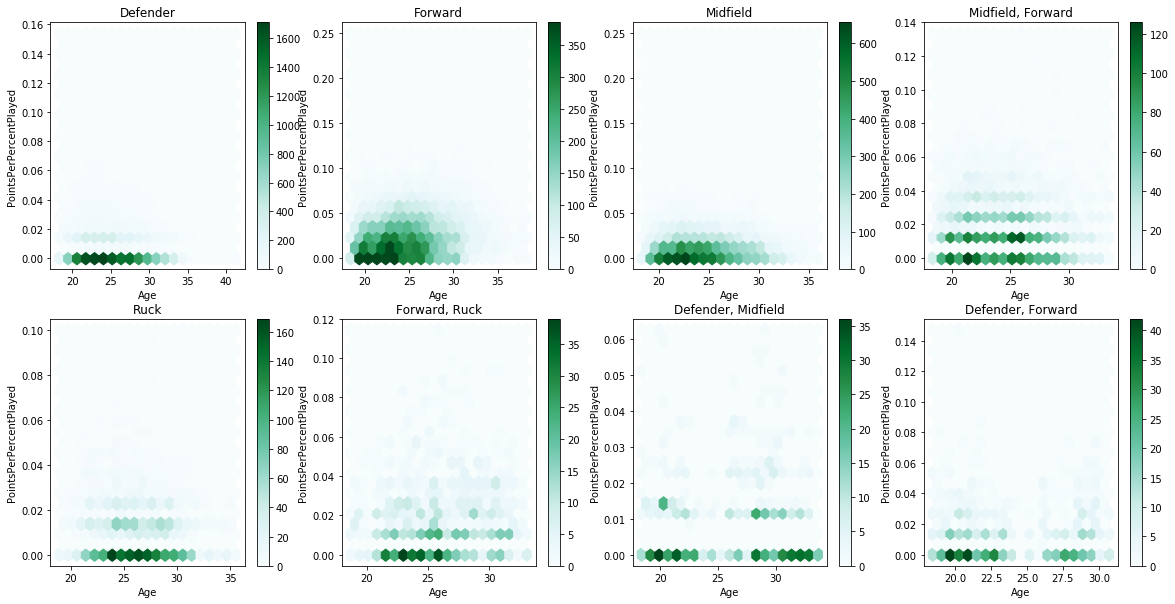

In [22]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_ML[df_ML.Position==hist_names[m]].plot.hexbin('Age','PointsPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Height:

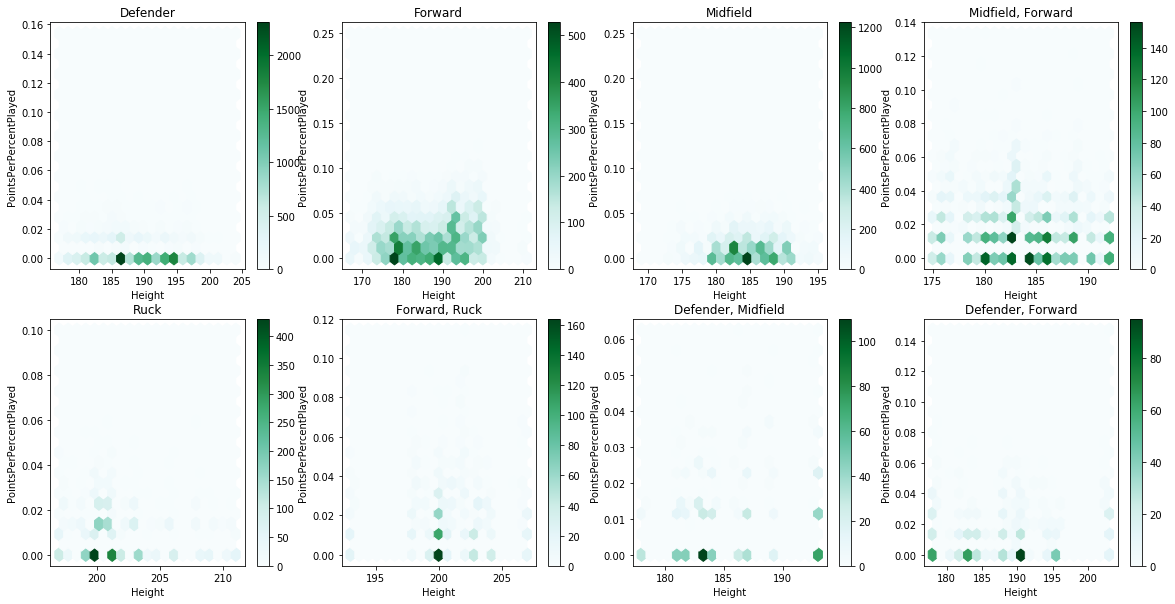

In [23]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_ML[df_ML.Position==hist_names[m]].plot.hexbin('Height','PointsPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Weight:

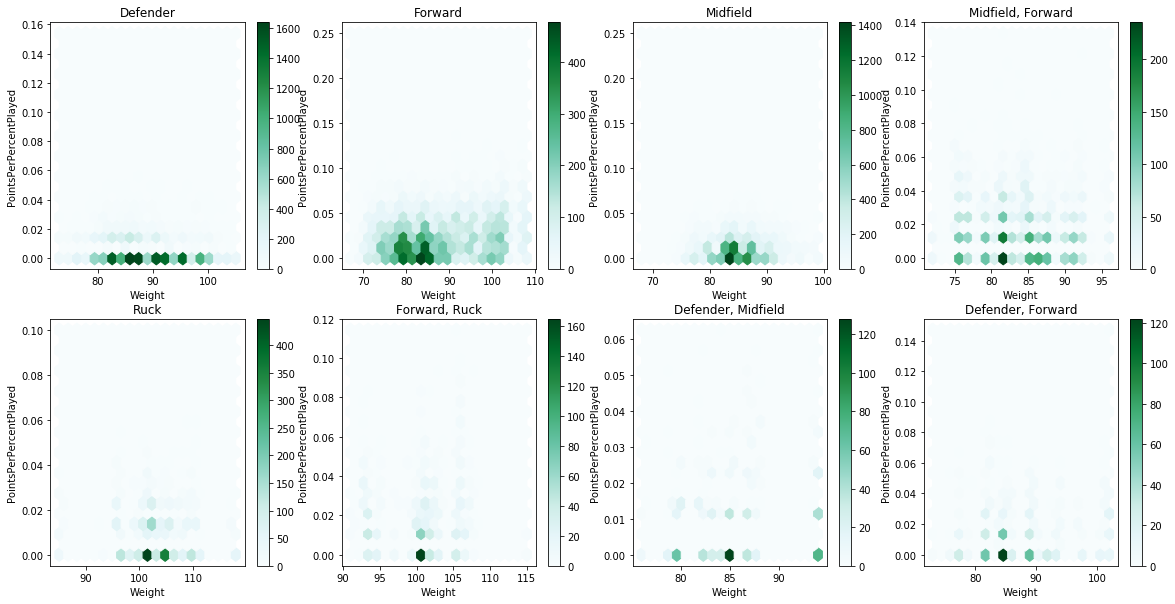

In [24]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_ML[df_ML.Position==hist_names[m]].plot.hexbin('Weight','PointsPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

In [25]:
df_ML.reset_index(inplace=True)
df_ML.drop(['Season','Round'],axis=1,inplace=True)

df_ML.set_index(['Date','Teams','Team'],inplace=True)
df_ML.sort_index(inplace=True)

### Scaling the data by the percent each player played each game:

In [26]:
templist=[]
for col in scaling_list:
    df_ML[col+'Scale'] = df_ML[col].multiply(df_ML.PercentPlayed/100,axis=0)
    templist.append(col+'Scale')
    
scaling_list += templist

### Merging players' stats into a team average:

In [27]:
number_list = scaling_list+normalize_list

In [28]:
df_ML[number_list] = df_ML[number_list].groupby(['Date','Teams','Team']).mean()

In [29]:
df_ML.reset_index(inplace=True)
df_ML.drop(['Player','Position','PercentPlayed','Teams'],axis=1,inplace=True)
df_ML.drop_duplicates(inplace=True)

## Offsetting columns for time series analysis:

In [30]:
lose #Columns whose rows that I don't want to shift

['Age',
 'Height',
 'Weight',
 'Age_n1',
 'Height_n1',
 'Weight_n1',
 'Age_n2',
 'Height_n2',
 'Weight_n2',
 'Age_n1_n2',
 'Height_n1_n2',
 'Weight_n1_n2']

In [31]:
Offset_List = number_list + ['WinLoss']

for x in lose:
    Offset_List.remove(x)

In [32]:
PointsList=[]

for column_name in Offset_List:
    df_ML[column_name+'Shift1'] = df_ML.set_index('Date',append=1).sort_index(level=1)\
        .groupby('Team')[column_name].shift().reset_index(['Date'], drop=1)
    
    PointsList.append(column_name+'Shift1')
    
    for i in range(2,6):
        df_ML[column_name+'Shift'+str(i)] = df_ML.set_index('Date',append=1).sort_index(level=1)\
            .groupby('Team')[column_name].shift(i).reset_index(['Date'], drop=1)
        
        df_ML[column_name+'Exp'+str(i)] = df_ML.set_index('Date',append=1).sort_index(level=1)\
            .groupby('Team')[column_name].rolling(window=i,min_periods=i,win_types='exponential')\
            .mean().groupby('Team').shift().reset_index(['Team','Date'], drop=1)
        
        PointsList.append(column_name+'Shift'+str(i))
        PointsList.append(column_name+'Exp'+str(i))

In [33]:
Offset_List.remove('WinLoss')

df_ML.drop(Offset_List,axis=1,inplace=True)

In [34]:
#Fixing nulls again because of shifting:
df_ML.dropna(inplace=True)

## Checking distribution differences between winners and losers via hypothesis testing:

### Win and Loss Distributions of Features:

In [35]:
df_ML_win = df_ML.select_dtypes(include=['number'])[df_ML.WinLoss==1]

In [36]:
df_ML_loss = df_ML.select_dtypes(include=['number'])[df_ML.WinLoss==0]

In [37]:
number_list = df_ML_win.columns 
len(number_list)

1750

In [38]:
series_list=[]

for m in range(1750):
    test_stat1, p_value1 = ttest_ind(df_ML_win[number_list[m]], df_ML_loss[number_list[m]])
    
    series_list.append([number_list[m], test_stat1])

df_stat = pd.DataFrame(series_list, columns=['column_name','test_stat_mean'])
df_stat.set_index('column_name',inplace=True)
df_stat.replace([np.inf, -np.inf], np.nan,inplace=True)

In [39]:
df_stat.dropna().abs().sort_values('test_stat_mean',ascending=False)['test_stat_mean'].head(20)

column_name
Age_n2               19.56
Age_n1_n2            19.56
MarginExp5           13.57
Margin_n1Exp5        13.55
Age_n1               13.18
MarginExp4           13.10
Margin_n1Exp4        12.98
Inside50sScaleExp5   12.92
Age                  12.88
Inside50sExp5        12.79
Margin_n2Exp5        12.56
Score_n2Exp5         12.56
Margin_n1_n2Exp5     12.56
WinLossExp5          12.56
Score_n1_n2Exp5      12.53
Inside50sScaleExp4   12.34
MarginExp3           12.32
Inside50sExp4        12.29
Margin_n2Exp4        12.20
Score_n2Exp4         12.20
Name: test_stat_mean, dtype: float64

### The features with the biggest mean discrepancy between the winning and losing teams are Age, previous Margin, Inside 50s, and previous Win-Loss record. 

# Machine Learning:
## Making dummy variables:

In [40]:
df_ML.select_dtypes(include=['object']).head()

,Team,Opposition,Venue
1980,Collingwood,Western Bulldogs,Docklands
2002,Western Bulldogs,Collingwood,Docklands
2024,Adelaide,Sydney,S.C.G.
2046,Sydney,Adelaide,S.C.G.
2068,Brisbane Lions,Essendon,Docklands


In [41]:
categorical_list = df_ML.select_dtypes(include=['object']).columns

In [42]:
df_ML = pd.get_dummies(df_ML,columns=categorical_list,drop_first=True)

In [43]:
df_ML = df_ML[df_ML.WinLoss!=.5]

### Alternating between dropping wins and losses to remove one team from each game and avoid redundant information that could skew the model:

In [44]:
row_list=[]
for row in range(len(df_ML)):
    if (row % 2!=0) & (df_ML.WinLoss.iloc[row]==0):
        row_list.append(df_ML.index[row])
    elif (row % 2==0) & (df_ML.WinLoss.iloc[row]!=0):
        row_list.append(df_ML.index[row])

In [45]:
df_ML.drop(row_list,inplace=True)

In [46]:
df_ML.WinLoss.value_counts()

1.00    715
0.00    715
Name: WinLoss, dtype: int64

## Spliting Data and Creating Model:

In [47]:
X = df_ML.drop(['WinLoss','Date'],axis=1)
y = df_ML['WinLoss']

In [48]:
from sklearn.linear_model import LogisticRegression

#for function below
from sklearn.model_selection import TimeSeriesSplit

from time import time
from sklearn.metrics import make_scorer,confusion_matrix,accuracy_score,\
    precision_score,recall_score,f1_score,roc_auc_score,matthews_corrcoef

In [49]:
def metrics_function1(target,pred):
    return accuracy_score(target, pred),precision_score(target, pred),\
        recall_score(target, pred),f1_score(target, pred),\
        roc_auc_score(target, pred),matthews_corrcoef(target, pred)

def TSer1_TEST(clf,X_all,y_all,folds_num,row_factor):
    start=time()
    
    TSer1=TimeSeriesSplit(n_splits=folds_num)
    print ('{}:'.format(clf.__class__.__name__),'\n')
    
    acc_list_train=[]
    acc_list_test=[]
    prc_list_train=[]
    prc_list_test=[]
    rcal_list_train=[]
    rcal_list_test=[]
    f1_list_train=[]
    f1_list_test=[]
    matt_list_train=[]
    matt_list_test=[]
    AUC_list_train=[]
    AUC_list_test=[]
    
    samp_size=X_all.shape[0]//row_factor
    
    for fold,(train_index,target_index) in enumerate(TSer1.split(X_all[:samp_size],
                                                                y_all[:samp_size])):
        X_train=X_all.iloc[train_index].values
        y_train=y_all.iloc[train_index].values

        X_test=X_all.iloc[target_index].values
        y_test=y_all.iloc[target_index].values
        
        clf.fit(X_train,y_train)
        y_pred1=clf.predict(X_train)
        y_pred2=clf.predict(X_test)

        train_acc,train_prc,train_rcal,train_f1,train_auc,train_matt=metrics_function1(y_train,y_pred1)
        
        test_acc,test_prc,test_rcal,test_f1,test_auc,test_matt=metrics_function1(y_test,y_pred2)
        
        acc_list_train.append(train_acc)
        acc_list_test.append(test_acc)
        prc_list_train.append(train_prc)
        prc_list_test.append(test_prc)
        rcal_list_train.append(train_rcal)
        rcal_list_test.append(test_rcal)
        
        f1_list_train.append(train_f1)
        f1_list_test.append(test_f1)
        matt_list_train.append(train_matt)
        matt_list_test.append(test_matt)
        AUC_list_train.append(train_auc)
        AUC_list_test.append(test_auc)
    
    print("Averages:"'\n')
    
    print("Train acc: {}, Test acc: {}".format(np.mean(acc_list_train),
                                               np.mean(acc_list_test)))
    print("Train prc: {}, Test prc: {}".format(np.mean(prc_list_train),
                                               np.mean(prc_list_test)))
    print("Train recall: {}, Test recall: {}".format(np.mean(rcal_list_train),
                                                     np.mean(rcal_list_test)),'\n')
    
    print("Train f1: {}, Test f1: {}".format(np.mean(f1_list_train),
                                             np.mean(f1_list_test)))
    print("Train MattCC: {}, Test MattCC: {}".format(np.mean(matt_list_train),
                                                     np.mean(matt_list_test)))
    print("Train AUC: {}, Test AUC: {}".format(np.mean(AUC_list_train),
                                               np.mean(AUC_list_test)),'\n'*2)
        
    print("Sample Size: {}, Folds Num: {}, Time: {}".format(samp_size,folds_num,
                                                            time()-start),'\n'*2)

In [50]:
clf_A1 = LogisticRegression(penalty='l1',tol=1e-1,C=.15,solver='liblinear',random_state=0)

In [51]:
TSer1_TEST(clf_A1, X, y, 5, 1)

LogisticRegression: 

Averages:

Train acc: 0.8501525648349675, Test acc: 0.838655462184874
Train prc: 0.8449309520253868, Test prc: 0.831658172769853
Train recall: 0.8592061007445702, Test recall: 0.8521008403361344 

Train f1: 0.851979644441264, Test f1: 0.8416415280140985
Train MattCC: 0.7004263689305009, Test MattCC: 0.6776195330162842
Train AUC: 0.8501525648349675, Test AUC: 0.838655462184874 


Sample Size: 1430, Folds Num: 5, Time: 0.5781006813049316 




### Win percentage if choosing the favorite between 2009-2013:
(according to https://www.bigfooty.com/forum/threads/how-often-do-favourites-win.1004437/)

##### 2009: 50/72 or 69.4% - (only data available)
##### 2010: 109/176 or 61.9%
##### 2011: 142/187 or 75.9%
##### 2012: 155/198 or 78.2%
##### At that point in 2013: 41/54 or 75.9%

### The best outcome over those years was about 78%.
### Our model predicts the winner over 83% of the time.

# Predicting AFL Fantasy points:

In [52]:
df_F = df.copy()
fantasy_points = {'Kicks':3,'Handballs':2,'Marks':3,'Tackles':4,'FreesFor':1,
                  'FreesAgainst':-3,'Hitouts':1,'Goals':6,'Behinds':1}

In [53]:
new_list=[]

#Creating fantasy columns
for keys in fantasy_points.keys():
    df_F[keys+'_fantasy'] = df_F[keys]*fantasy_points[keys]
    new_list.append(keys+'_fantasy')
    
df_F['fantasy_points'] = pd.Series()   
    
for cols in fantasy_points.keys():
    df_F.fantasy_points = df_F.fantasy_points.add(df_F[cols+'_fantasy'],fill_value=0)

df_F['target'] = df_F.fantasy_points

In [54]:
df_F[new_list+['fantasy_points']].head()

Kicks_fantasy  Handballs_fantasy  Marks_fantasy  \
Season Round                                                    
2012   R1                42                  8             15   
       R1                39                 24              9   
       R1                15                 24             12   
       R1                42                 10             18   
       R1                15                  6              3   

              Tackles_fantasy  FreesFor_fantasy  FreesAgainst_fantasy  \
Season Round                                                            
2012   R1                  20                 0                    -3   
       R1                   8                 0                    -3   
       R1                  12                 2                     0   
       R1                  28                 2                     0   
       R1                   4                 0                     0   

              Hitouts_fantasy  Goals_fantasy  Behinds_fantasy  fantasy_points  
Season Round                                                                   
2012   R1                   0             12                5           99.00  
       R1                   0             12                0           89.00  
       R1                   0              0                0           65.00  
       R1                   0              6                3          109.00  
       R1                   0              0                0           28.00

In [55]:
df_F.insert(11, 'FantasyPerPercentPlayed',df_F['fantasy_points']/df_F['PercentPlayed'])

In [56]:
df_F.drop(new_list,axis=1,inplace=True)
new_scaling_list = new_scaling_list + ['fantasy_points'] + ['FantasyPerPercentPlayed']

# Fantasy points by position:

In [57]:
for names in hist_names:
    print(names+':','\n')
    print(df_F[df_F.Position==names].fantasy_points.describe(),'\n'*2)

Defender: 

count   20950.00
mean       64.59
std        24.83
min        -3.00
25%        47.00
50%        63.00
75%        80.00
max       189.00
Name: fantasy_points, dtype: float64 


Forward: 

count   15047.00
mean       66.19
std        25.39
min        -3.00
25%        49.00
50%        65.00
75%        83.00
max       204.00
Name: fantasy_points, dtype: float64 


Midfield: 

count   14970.00
mean       83.18
std        28.56
min         0.00
25%        64.00
50%        83.00
75%       102.00
max       195.00
Name: fantasy_points, dtype: float64 


Midfield, Forward: 

count   4216.00
mean      76.58
std       26.72
min        0.00
25%       58.00
50%       76.00
75%       94.00
max      187.00
Name: fantasy_points, dtype: float64 


Ruck: 

count   3111.00
mean      76.55
std       26.09
min       -1.00
25%       59.00
50%       76.00
75%       94.00
max      177.00
Name: fantasy_points, dtype: float64 


Forward, Ruck: 

count   1099.00
mean      68.30
std       25.71
min    

### There is a commonly held belief that, in AFL Fantasy, midfielders are the best position for points, and this information confirms that.

## Normalizing all players by round (n1):

In [58]:
templist=[]
for col in new_scaling_list:
    df_F[col+'_n1'] = df_F.groupby(['Season','Round'])[col].transform(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)))    
    templist.append(col+'_n1')

new_scaling_list += templist

In [59]:
templist=[]
for col in new_normalize_list:
    df_F[col+'_n1'] = df_F.groupby(['Season','Round'])[col].transform(lambda x: zscore(x,ddof=1))
    templist.append(col+'_n1')

new_normalize_list += templist

## Normalizing further by game (n2):

In [60]:
df_F = df_F.set_index(['Teams'],append=1).sort_index()

In [61]:
templist=[]
for col in new_scaling_list:
    df_F[col+'_n2'] = df_F.groupby(['Season','Round','Teams'])[col].transform(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)))
    templist.append(col+'_n2')

new_scaling_list += templist

In [62]:
templist=[]
for col in new_normalize_list:
    df_F[col+'_n2'] = df_F.groupby(['Season','Round','Teams'])[col].transform(lambda x: zscore(x,ddof=1))
    templist.append(col+'_n2')

new_normalize_list += templist

In [63]:
df_F.fillna(0,inplace=True)

## Fantasy points per percent of game played relative to other players that round by position:

## Age:

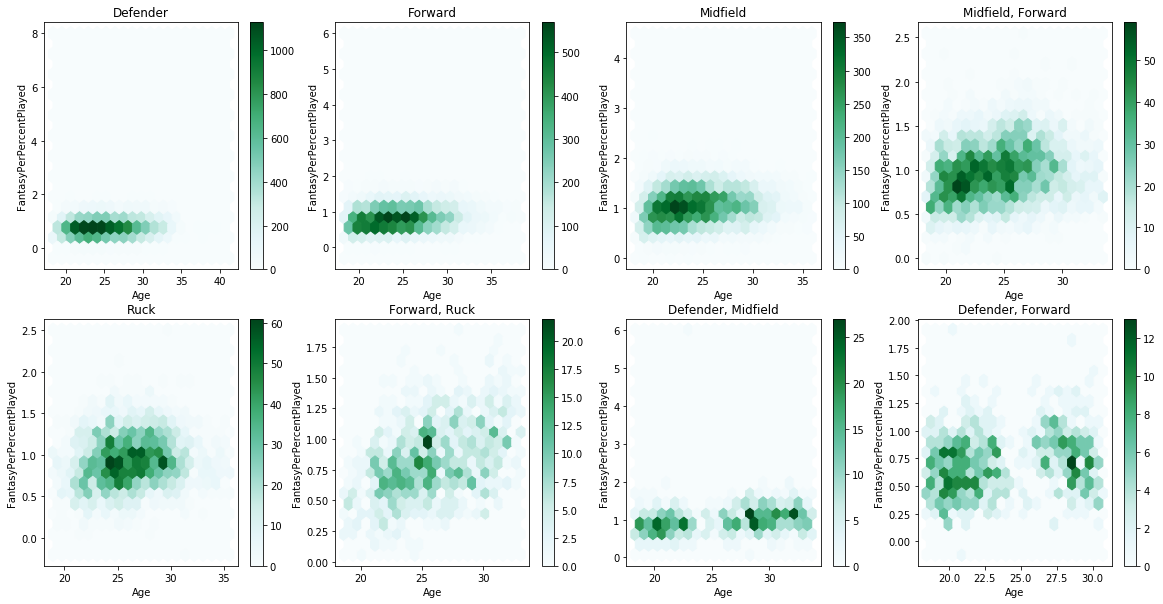

In [64]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_F[df_F.Position==hist_names[m]].plot.hexbin('Age','FantasyPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Height:

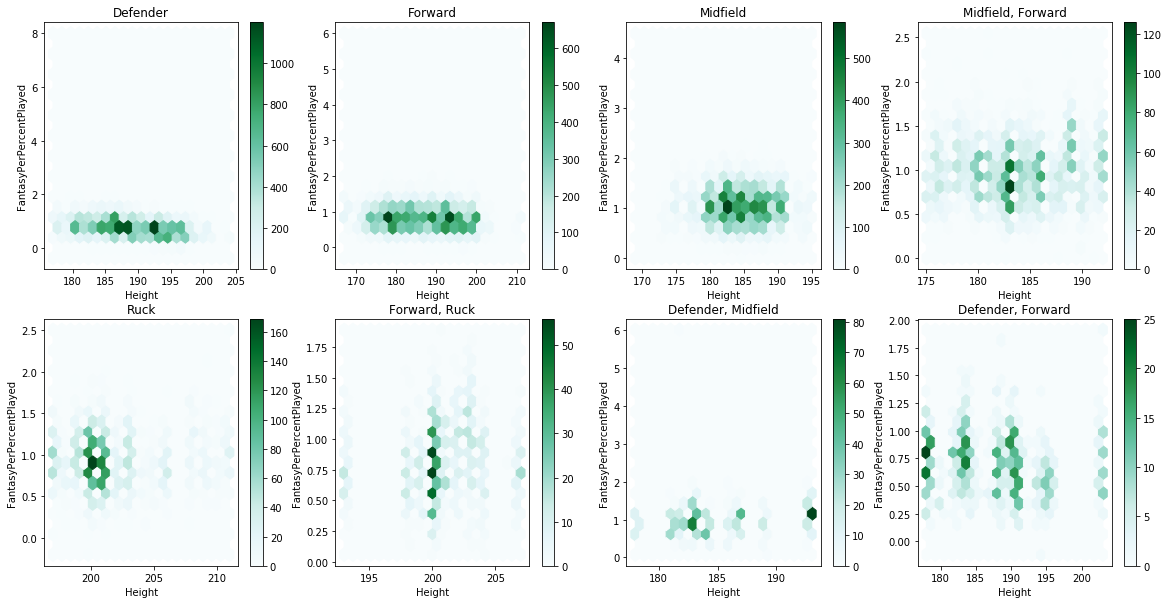

In [65]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_F[df_F.Position==hist_names[m]].plot.hexbin('Height','FantasyPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Weight:

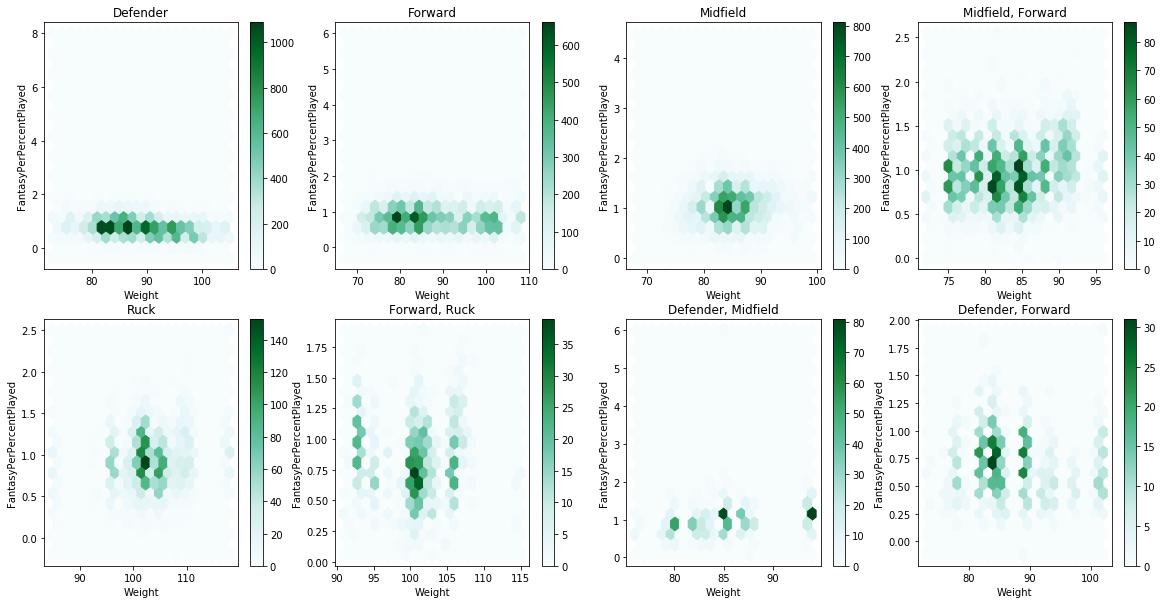

In [66]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_F[df_F.Position==hist_names[m]].plot.hexbin('Weight','FantasyPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

In [67]:
df_F.reset_index(inplace=True)
df_F.drop(['Season','Round'],axis=1,inplace=True)

df_F = df_F.set_index(['Date','Teams','Team']).sort_index()

### Scaling the data by the percent played:

In [68]:
templist=[]
for col in new_scaling_list:
    df_F[col+'Scale'] = df_F[col].multiply(df_F.PercentPlayed/100,axis=0)
    templist.append(col+'Scale')
    
new_scaling_list += templist

In [69]:
new_number_list = new_scaling_list+new_normalize_list

## Offsetting columns for time series analysis:

In [70]:
df_F.reset_index(inplace=True)
df_F.drop(['Teams','PercentPlayed'],axis=1,inplace=True)

In [71]:
Offset_Fantasy_List = new_number_list + ['WinLoss']

for x in lose:
    Offset_Fantasy_List.remove(x)

### Creating a 5-game auto-regression and exponentially weighted moving average for all relevant features:

In [72]:
FantasyList=[]

for column_name in Offset_Fantasy_List:
    df_F[column_name+'Shift1'] = df_F.set_index('Date',append=1).sort_index(level=1)\
        .groupby('Player')[column_name].shift().reset_index(['Date'], drop=1)
 
    FantasyList.append(column_name+'Shift1')

    for i in range(2,6):
        df_F[column_name+'Shift'+str(i)] = df_F.set_index('Date',append=1).sort_index(level=1)\
            .groupby('Player')[column_name].shift(i).reset_index(['Date'], drop=1)

        df_F[column_name+'Exp'+str(i)] = df_F.set_index('Date',append=1).sort_index(level=1)\
            .groupby('Player')[column_name].rolling(window=i,min_periods=i,win_types='exponential')\
            .mean().groupby('Player').shift().reset_index(['Player','Date'], drop=1)

        FantasyList.append(column_name+'Shift'+str(i))
        FantasyList.append(column_name+'Exp'+str(i))

In [73]:
df_F.drop(Offset_Fantasy_List,axis=1,inplace=True)

### Offsetting the target to see the error for predictions within 5 games:

In [74]:
target_list = []

for i in range(1,10):
    df_F['targetShift'+str(-i)] = df_F.set_index('Date',append=1).sort_index(level=1).groupby('Player')['target'].shift(-i).reset_index('Date', drop=1)
    
    target_list.append('targetShift'+str(-i))

In [75]:
target_list = ['target'] + target_list
target_list

['target',
 'targetShift-1',
 'targetShift-2',
 'targetShift-3',
 'targetShift-4',
 'targetShift-5',
 'targetShift-6',
 'targetShift-7',
 'targetShift-8',
 'targetShift-9']

In [76]:
#Fixing nulls again because of shifting:
df_F.dropna(inplace=True)

# Correlation Between AFL Fantasy Points and Other Features by Position:

In [77]:
column_list = df_F.select_dtypes(include=['number']).drop(['target']+target_list,axis=1).columns

## Defender:

In [78]:
df_F[df_F.Position=='Defender'][column_list].corrwith(df_F[df_F.Position=='Defender'].target).sort_values(ascending=False)

DisposalsExp5                       0.51
FantasyPerPercentPlayedScaleExp5    0.50
fantasy_pointsExp5                  0.50
Disposals_n1Exp5                    0.50
DisposalsExp4                       0.50
                                    ... 
OnePercenters_n1_n2Exp5            -0.25
Height_n1_n2                       -0.26
Height_n2                          -0.26
Height                             -0.26
Height_n1                          -0.26
Length: 1893, dtype: float64

## Forward:

In [79]:
df_F[df_F.Position=='Forward'][column_list].corrwith(df_F[df_F.Position=='Forward'].target).sort_values(ascending=False)

FantasyPerPercentPlayedScaleExp5    0.38
fantasy_pointsExp5                  0.38
fantasy_points_n1Exp5               0.37
fantasy_pointsExp4                  0.37
FantasyPerPercentPlayedScaleExp4    0.37
                                    ... 
Hitouts_n1Shift5                   -0.02
Hitouts_n1_n2ScaleShift5           -0.02
Hitouts_n2ScaleShift5              -0.02
Hitouts_n1_n2Shift5                -0.02
Hitouts_n2Shift5                   -0.02
Length: 1893, dtype: float64

## Midfield:

In [80]:
df_F[df_F.Position=='Midfield'][column_list].corrwith(df_F[df_F.Position=='Midfield'].target).sort_values(ascending=False)

fantasy_pointsExp5                  0.48
FantasyPerPercentPlayedScaleExp5    0.48
DisposalsExp5                       0.48
fantasy_points_n1Exp5               0.47
Disposals_n1Exp5                    0.47
                                    ... 
Height                             -0.01
OnePercenters_n1Shift1             -0.01
Height_n1                          -0.01
Height_n1_n2                       -0.01
Height_n2                          -0.01
Length: 1893, dtype: float64

## Midfield, Forward:

In [81]:
df_F[df_F.Position=='Midfield, Forward'][column_list].corrwith(df_F[df_F.Position=='Midfield, Forward'].target).sort_values(ascending=False)

fantasy_pointsExp5                  0.44
FantasyPerPercentPlayedScaleExp5    0.44
DisposalsExp5                       0.44
FantasyPerPercentPlayedScaleExp4    0.44
fantasy_pointsExp4                  0.44
                                    ... 
WinLossShift5                      -0.01
Score_n1_n2Shift5                  -0.01
Margin_n1Shift5                    -0.02
Score_n1Shift5                     -0.03
ScoreShift5                        -0.03
Length: 1893, dtype: float64

## Ruck:

In [82]:
df_F[df_F.Position=='Ruck'][column_list].corrwith(df_F[df_F.Position=='Ruck'].target).sort_values(ascending=False)

FantasyPerPercentPlayedScaleExp5    0.44
fantasy_pointsExp5                  0.44
fantasy_points_n1Exp5               0.43
fantasy_pointsScaleExp5             0.43
FantasyPerPercentPlayedScaleExp4    0.43
                                    ... 
MarksInside50_n2Exp3               -0.10
MarksInside50_n2Exp5               -0.10
MarksInside50_n1_n2Exp5            -0.10
MarksInside50_n1_n2Exp4            -0.10
MarksInside50_n2Exp4               -0.10
Length: 1893, dtype: float64

## Forward, Ruck:

In [83]:
df_F[df_F.Position=='Forward, Ruck'][column_list].corrwith(df_F[df_F.Position=='Forward, Ruck'].target).sort_values(ascending=False)

Age_n1                          0.41
Age                             0.41
Age_n2                          0.41
Age_n1_n2                       0.41
fantasy_pointsExp5              0.40
                                ... 
OnePercenters_n1_n2ScaleExp4   -0.13
OnePercenters_n1_n2Exp5        -0.13
OnePercenters_n2Exp5           -0.13
OnePercenters_n2ScaleExp5      -0.13
OnePercenters_n1_n2ScaleExp5   -0.13
Length: 1893, dtype: float64

## Defender, Midfield:

In [84]:
df_F[df_F.Position=='Defender, Midfield'][column_list].corrwith(df_F[df_F.Position=='Defender, Midfield'].target).sort_values(ascending=False)

Disposals_n1ScaleExp5         0.47
Disposals_n1ScaleExp4         0.46
Disposals_n1Exp5              0.46
DisposalsScaleExp5            0.46
fantasy_points_n1ScaleExp5    0.46
                              ... 
BouncesExp3                  -0.04
Bounces_n1Shift3             -0.04
Bounces_n1Exp3               -0.04
BouncesShift3                -0.04
Margin_n1Shift1              -0.05
Length: 1893, dtype: float64

## Defender, Forward:

In [85]:
df_F[df_F.Position=='Defender, Forward'][column_list].corrwith(df_F[df_F.Position=='Defender, Forward'].target).sort_values(ascending=False)

fantasy_pointsScaleExp4               0.43
DisposalsExp4                         0.42
DisposalsScaleExp4                    0.42
fantasy_points_n1ScaleExp4            0.42
UncontendedPossessionsScaleExp4       0.42
                                      ... 
PointsPerPercentPlayed_n1_n2Shift2   -0.13
PointsPerPercentPlayed_n2Shift2      -0.13
PointsPerPercentPlayedScaleShift2    -0.13
PointsPerPercentPlayed_n1Shift2      -0.15
PointsPerPercentPlayedShift2         -0.15
Length: 1893, dtype: float64

# Machine Learning:
## Making dummy variables:

In [86]:
df_F.select_dtypes(include=['object']).head()

,Team,Player,Position,Opposition,Venue
1983,Collingwood,"Clarke, Martin",Defender,Western Bulldogs,Docklands
1984,Collingwood,"Cloke, Travis",Forward,Western Bulldogs,Docklands
1985,Collingwood,"Dawes, Chris",Forward,Western Bulldogs,Docklands
1986,Collingwood,"Fasolo, Alex",Forward,Western Bulldogs,Docklands
1987,Collingwood,"Goldsack, Tyson",Defender,Western Bulldogs,Docklands


In [87]:
categorical_list2 = df_F.select_dtypes(include=['object']).drop('Player',axis=1).columns

In [88]:
df_F = pd.get_dummies(df_F,columns=categorical_list2,drop_first=True)

## Spliting Data and Creating Model:

In [89]:
df_F.set_index(['Player','Date'],inplace=True)

In [90]:
X2 = df_F.drop(target_list,axis=1)

#Assigns variables to offset target values: 
for i in range(len(target_list)):
    globals()['y2_'+str(i)] = df_F[target_list[i]]

In [91]:
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [92]:
def metrics_function2(target,pred):
    return mean_squared_error(target,pred),mean_absolute_error(target,pred),r2_score(target,pred)

def TSer2_TEST(clf,X_all,y_all,folds_num,row_factor):
    start=time()
    
    TSer2=TimeSeriesSplit(n_splits=folds_num)
    print ('{}:'.format(clf.__class__.__name__),'\n')
    
    samp_size=X_all.shape[0]//row_factor
    
    MSE_list_train=[]
    MSE_list_test=[]
    MAE_list_train=[]
    MAE_list_test=[]
    R2_list_train=[]
    R2_list_test=[]
    
    for fold,(train_index,target_index) in enumerate(TSer2.split(X_all[:samp_size],
                                                                y_all[:samp_size])):
        X_train=X_all.iloc[train_index].values
        y_train=y_all.iloc[train_index].values

        X_test=X_all.iloc[target_index].values
        y_test=y_all.iloc[target_index].values
        
        clf.fit(X_train,y_train)
        y_pred1=clf.predict(X_train)
        y_pred2=clf.predict(X_test)

        train_MSE,train_MAE,train_R2=metrics_function2(y_train,y_pred1)
        test_MSE,test_MAE,test_R2=metrics_function2(y_test,y_pred2)
        
        MSE_list_train.append(train_MSE)
        MSE_list_test.append(test_MSE)
        MAE_list_train.append(train_MAE)
        MAE_list_test.append(test_MAE)
        R2_list_train.append(train_R2)
        R2_list_test.append(test_R2)
        
    print("Train MSE: {}, Test MSE: {}".format(np.mean(MSE_list_train),
                                               np.mean(MSE_list_test)),'\n'*2) 
    print("Train MAE: {}, Test MAE: {}".format(np.mean(MAE_list_train),
                                               np.mean(MAE_list_test)),'\n'*2)
    print("Train R2: {}, Test R2: {}".format(np.mean(R2_list_train),
                                             np.mean(R2_list_test)),'\n'*2)   
        
    print("Sample Size: {}, Folds Num: {}, Time: {}".format(samp_size,folds_num,
                                                            time()-start),'\n'*2)

In [93]:
clf_A2 = Ridge(alpha=1e3,random_state=0)

## Predicting AFL Fantasy points for the next 5 games:

### Current game's point prediction:

In [94]:
TSer2_TEST(clf_A2, X2, y2_0, 5, 1)

Ridge: 

Train MSE: 509.70355437756353, Test MSE: 511.9479484564269 


Train MAE: 17.785420227775774, Test MAE: 17.774061831540884 


Train R2: 0.31316127416711836, Test R2: 0.30011231252820414 


Sample Size: 46389, Folds Num: 5, Time: 14.18442988395691 




### Two games prediction:

In [95]:
TSer2_TEST(clf_A2, X2, y2_1, 5, 1)

Ridge: 

Train MSE: 521.8715431778412, Test MSE: 520.043603029048 


Train MAE: 17.981603047292133, Test MAE: 17.9305735735347 


Train R2: 0.29475455401711664, Test R2: 0.28719902706507705 


Sample Size: 46389, Folds Num: 5, Time: 13.367754936218262 




### Three games out:

In [96]:
TSer2_TEST(clf_A2, X2, y2_2, 5, 1)

Ridge: 

Train MSE: 531.4017922979071, Test MSE: 524.8685418143552 


Train MAE: 18.11919211449625, Test MAE: 18.00780674472902 


Train R2: 0.28443890049725706, Test R2: 0.2793444025527128 


Sample Size: 46389, Folds Num: 5, Time: 13.347766637802124 




### Four games out:

In [97]:
TSer2_TEST(clf_A2, X2, y2_3, 5, 1)

Ridge: 

Train MSE: 537.5468708956925, Test MSE: 529.4581536045524 


Train MAE: 18.249912445653127, Test MAE: 18.09089627234831 


Train R2: 0.2741952544268488, Test R2: 0.27247590663431165 


Sample Size: 46389, Folds Num: 5, Time: 13.559635877609253 




### Five games out:

In [98]:
TSer2_TEST(clf_A2, X2, y2_4, 5, 1)

Ridge: 

Train MSE: 540.5273121576508, Test MSE: 530.6713295556594 


Train MAE: 18.31491418732723, Test MAE: 18.11267694663715 


Train R2: 0.27091788820864926, Test R2: 0.269903238253633 


Sample Size: 46389, Folds Num: 5, Time: 13.145892143249512 




### Ten games out:

In [99]:
TSer2_TEST(clf_A2, X2, y2_9, 5, 1)

Ridge: 

Train MSE: 552.8331744330324, Test MSE: 549.1657772508643 


Train MAE: 18.504912801817817, Test MAE: 18.422941754158735 


Train R2: 0.2557304966213424, Test R2: 0.24876452370268928 


Sample Size: 46389, Folds Num: 5, Time: 13.002979516983032 


